
**TOV Stars with Tabulated Equation of State**

N. Stergioulas

Aristotle University of Thessaloniki

v1.0 (June 2018)

###### Content provided under a Creative Commons Attribution license, [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/); code under [GNU GPLv3 License](https://choosealicense.com/licenses/gpl-3.0/). (c)2018 [Nikolaos Stergioulas](http://www.astro.auth.gr/~niksterg/)


In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy import integrate
from scipy import optimize
from scipy.interpolate import PchipInterpolator
import sys
from decimal import Decimal
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from IPython.display import Image

# The TOV equations for spherical stars

Consider the metric for a spherically symmetric, stationary and asymptotic spacetime in Schwarzshild coordinates $t, r, \theta, \phi$
$$ ds^2 = -e^{\nu}dt^2 +e^{\lambda}dr^2 + r^2(d\theta^2+\sin^2\theta d\phi^2)$$
The TOV system in units $c=G=1$ is
$$ P = P(\epsilon),$$
$$ \frac{dP}{dr} = -\frac{(\epsilon+P)(m+4\pi r^3P)}{r(r-2m)},$$
$$ \frac{dm}{dr} = 4\pi r^2 \epsilon$$
$$ \frac{d\nu}{dr} = -\frac{2}{\epsilon+P}\frac{dP}{dr}=\frac{2(m+4\pi r^3P)}{r(r-2m)},$$
$$ \lambda = -\ln\left(1-\frac{2m}{r}\right),$$
The central values are
$$ P(0) = P_c,$$
$$ m(0) = 0,$$
$$ \nu(0) = -1.$$
where the last choice is arbitrary (after the interior solution is obtained, $\nu$ will be shifted to match the Schwarzschild exterior solution at the surface).

Near the center, we do a series expansion 
$$P(r) \simeq P_c -(2\pi)(\epsilon_c+P_c) \left( P_c+\frac{1}{3}\epsilon_c \right) r^2 + O(r^4),$$
$$ m(r) \simeq \frac{4}{3}\pi\epsilon_cr^3 + O(r^4),$$
$$ \nu(r) \simeq \nu_c + 4\pi \left(P_c+ \frac{1}{3}\epsilon_c \right)r^2 + O(r^4).$$
The value of $\nu$ at the surface is 
$$ \nu_\star = -\lambda_\star = \ln\left(1-\frac{2M}{R}\right).$$
The gravitational mass can be obtained as 
$$ M = \int_0^R 4\pi r^2\epsilon dr,$$
or as
$$ M = \int_0^R 4\pi r^2 e^{(\nu+\lambda)/2}(\epsilon +3P)dr,$$
The baryon mass of the star is
$$ M_0 = \int_0^R 4\pi r^2 e^{\lambda/2}\rho dr. $$


# Tabulated equation of state

A tabulated EOS in the rns1.1 format is read.

In the numerical implementation, we use a length scale of $M_\odot =1$. For the output, units are also converted to CGS.

In [2]:
# constants in CGS
mb = 1.66e-24
c = 2.9979e10
G=6.67408e-8
Msun=1.989e33
# scales
Length = G*Msun/c**2
Time = Length/c
Density = Msun/Length**3

In [3]:
# load eos file
eos_name = 'FPS_PP_HnG.dat'
#eos_name = 'EOS-RNS1/FPS_PP.dat'
N_eos = int(open(eos_name).readline().rstrip())

e_over_c2_CGS, P_CGS, H_c2_CGS, n_CGS = np.loadtxt(eos_name, skiprows=1, unpack=True)

# make dimensionless

epsilon = e_over_c2_CGS/Density
pressure = P_CGS/(Density*c**2)
enthalpy = H_c2_CGS/c**2
density = mb*n_CGS*Length**3/Msun

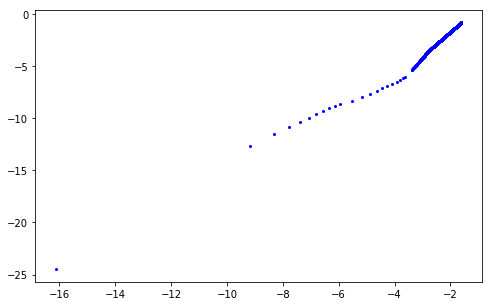

In [4]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(np.log10(density), np.log10(pressure) , 'o', color='blue', markersize=2)
#ax.plot(np.log10(e_over_c2_CGS), np.log10(P_CGS), 'o', color='blue', markersize=2)
#ax.set_xlim(20,37)
#ax.set_ylim(8,37)

plt.show()

In [5]:
log_epsilon = np.log10(epsilon)
log_pressure = np.log10(pressure)
log_density = np.log10(density)

log_pressure_of_log_density = PchipInterpolator(log_density,log_pressure)
log_density_of_log_pressure = PchipInterpolator(log_pressure,log_density)
log_epsilon_of_log_density = PchipInterpolator(log_density,log_epsilon)
log_epsilon_of_log_pressure = PchipInterpolator(log_pressure,log_epsilon)

In [6]:
display( pow(10.0,log_pressure_of_log_density(np.log10(density[0]))) ,
pow(10.0,log_density_of_log_pressure(np.log10(pressure[0]))) ,
     pow(10.0,log_epsilon_of_log_density(np.log10(density[0])))  ,
       pow(10.0,log_epsilon_of_log_pressure(np.log10(pressure[0]))))

3.0663281255972384e-25

7.320552784290218e-17

7.320552753626882e-17

7.320552753626882e-17

## Choose the central density and find the central pressure

In [7]:
#rho_c = 1.444e-3
#rho_c = 1.5*rho1
#9.92770e+14
rho_c = 5.9e+14/Density
eps_c = pow(10.0,log_epsilon_of_log_density(np.log10(rho_c)))
P_c = pow(10.0,log_pressure_of_log_density(np.log10(rho_c)))

display(rho_c)
display(rho_c*Density, eps_c*Density)

0.0009558570537800262

590000000000000.0

617794007964774.1

## Define the system of ODEs to be solved

Define the system $ f(r, {\mathbf y} (r))$ of differential equations to be solved:
$$ f(r, {\mathbf y} (r)) = \frac{d}{dr} \begin{bmatrix} y_0(r)\\ y_1(r) \\ y_2(r) \end{bmatrix}
  = \frac{d}{dr} \begin{bmatrix} P(r)\\ m(r) \\ \nu(r) \end{bmatrix} = 
  \begin{bmatrix} -\frac{(\epsilon+P)(m+4\pi r^3P)}{r(r-2m)} \\  
                  4\pi r^2 \epsilon \\
                  \frac{2(m+4\pi r^3P)}{r(r-2m)} 
                  \end{bmatrix}$$

In [8]:
def f(r, y):
    
    eps = pow(10.0,log_epsilon_of_log_pressure(np.log10(y[0])))
    
    return [ -( eps + y[0] )*( y[1] + 4.0*np.pi*pow(r,3.0)*y[0] )/( r*(r-2.0*y[1]) ), 
            
             4*np.pi*pow(r,2.0)*eps,
            
             2.0*( y[1] + 4.0*np.pi*pow(r,3.0)*y[0] )/( r*(r-2.0*y[1]) ) 
           ]

## Set the central value of $\nu_c$ and the starting values for the system of ODEs:

In [9]:
# set an arbitrary starting value for nu at the center
nu_c = -1.0

# set a safe max r, based on 4x radius of 1 Msun uniform density Newt. model
r_max = 4.0 * pow( 3.0/(4.0*np.pi*eps_c), 1.0/3.0)

# create an equidistant array of values for r
Npoints = (51, 101, 201, 401, 801, 1601,  3201, 6401, 12801, 25601, 51201)
#N = 25601
N = 801
r = np.linspace(0.0, r_max, N)
dr = r[1] - r[0]

# compute P, m, nu at r=dr by Taylor expansion
P_1 =  P_c - (2.0*np.pi)*(eps_c+P_c)*(P_c+(1.0/3.0)*eps_c)*pow(dr,2.0)
m_1 =  (4.0/3.0)*np.pi*eps_c*pow(dr, 3.0)
nu_1 = nu_c + 4.0*np.pi*(P_c+(1.0/3.0)*eps_c)*pow(dr,2.0)

# set starting values at r=dr for numerical integration
y0 = [P_1, m_1, nu_1]


## Numerical solution

Define an instant of the numerical solution of the ODE system

In [10]:

solve = integrate.ode(f)
solve.set_integrator('lsoda', rtol=1e-12, atol=1e-50,ixpr=True);
solve.set_initial_value(y0, dr);
solve.set_f_params();


Integrate from starting point to the surface (where $P=0$):

In [11]:
# create the solution vector
y = np.zeros((len(r), len(y0)))

# fill the solution vector with the values at the center
y[0,:] = [P_c, 0.0, nu_c]

# initialize counter
idx = 1

# integrate repeatedly to next grid point until P becomes zero
while solve.successful() and solve.t < r[-1] and solve.y[0]>0.0:
    
      y[idx, :] = solve.y
      solve.integrate(solve.t + dr)
      idx += 1

# last grid point with positive pressure
idxlast = idx-1 

# radius at last positive pressure grid point
R_last = r[idxlast]

# mass at last positive pressure grid point
Mass_last = y[idxlast][1]


In [12]:
display(R_last, Mass_last)

7.659067164707601

0.5825133801980029

Locate real radius by finding the location where h=1.0.

In [13]:
# use last 4 points to construct interpolant
r_data = np.zeros(4)
h_data = np.zeros(4)
eps_data = np.zeros(4)
rho_data = np.zeros(4)
P_data = np.zeros(4)
dmdr_data = np.zeros(4)

for i in range(idxlast-3,idxlast+1):
    r_data[i-idxlast+3] = r[i]
    eps_data[i-idxlast+3] = pow(10.0,log_epsilon_of_log_pressure(np.log10(y[i][0])))
    rho_data[i-idxlast+3] = pow(10.0,log_density_of_log_pressure(np.log10(y[i][0])))
    P_data[i-idxlast+3] = y[i][0]
    h_data[i-idxlast+3] = (eps_data[i-idxlast+3] + P_data[i-idxlast+3]) \
                           / rho_data[i-idxlast+3] -1.0
    dmdr_data[i-idxlast+3] = 4.0*np.pi*r[i]**2*eps_data[i-idxlast+3]

h_interp = PchipInterpolator(r_data, h_data)

# find the root using Brent's method
Radius = optimize.brentq( h_interp, r_data[0], r_data[3]+3*dr, xtol=1e-16 )

display(Radius)

7.648865595548828

Locate radius more accurately (to 4th-order) using a cubic Hermite interpolant of the specific enthalpy h-1.

In [14]:
def hHerm (r):
    r_last_1 = R_last-dr
    r_last = R_last
    w = (r-r_data[2])/dr
    m_last_1 = y[idxlast-1][1]
    m_last = y[idxlast][1]
    dhdr_last_1 = - (h_data[2]+1.0)*(m_last_1 + \
                            4.0*np.pi*r_last_1**3*y[idxlast-1][0])/ \
                           (r_last_1*(r_last_1-2.0*m_last_1))
    dhdr_last = - (h_data[3]+1.0)*(m_last + \
                           4.0*np.pi*r_last**3*y[idxlast][0])/ \
                           (r_last*(r_last-2.0*m_last))
    return (h_data[2]+1.0)*(2.0*pow(w,3.0)-3.0*pow(w,2.0)+1.0)+ \
                          (h_data[3]+1.0)*(2.0*pow(1.0-w,3.0)-3.0*pow(1.0-w,2.0)+1.0) \
                          + ( dhdr_last_1*(pow(w,3.0)-2.0*pow(w,2.0)+w) - \
                           dhdr_last*(pow(1-w,3.0)-2.0*pow(1-w,2.0)+1-w))*dr -1.0

In [15]:
Radius = optimize.brentq( hHerm, r_data[0], r_data[3]+3*dr, xtol=1e-16 )
display(Radius)

7.609368468174198

Correct mass by adding last missing piece by Simpson's rule (finding an intemediate point by pchip interpolation):

In [16]:
dmdr_interp_pchip = PchipInterpolator(r_data, dmdr_data)
dmdr_midpoint = dmdr_interp_pchip((R_last+Radius)/2)
Dmass_simps = (1.0/3.0)*(Radius-R_last)/2*(dmdr_interp_pchip(R_last)+4.0*dmdr_midpoint+dmdr_interp_pchip(Radius))

Mass = Mass_last + Dmass_simps

display(Mass)

0.5825133753827989

Construct table with main solution variables:

In [17]:
values = np.zeros((idxlast+1, 10)) 

for i in range(0,idxlast+1): 
    values[i][0] = r[i]
    values[i][1] = pow(10.0,log_density_of_log_pressure(np.log10(y[i][0]))) # rho
    values[i][2] = pow(10.0,log_epsilon_of_log_pressure(np.log10(y[i][0]))) # epsilon
    values[i][3] = y[i][0]   # P
    values[i][4] = y[i][1]   # m
    values[i][5] = y[i][2]   # nu (arbitrary)

values[0][6] = 0.0
for i in range(1,idxlast+1):     
    values[i][6] = - np.log(1.0-2.0*y[i][1]/r[i])   # lambda
    
values[:, 7] = (values[:, 2] + values[:, 3])/values[:, 1]  # h

values[:, 8] = - (values[:, 4] + 4.0*np.pi*pow(values[:, 0], 3.0)*values[:, 3])/ \
                     ( values[:, 0]*(values[:, 0] - 2.0*values[:, 4]))
                    # (e+P)^{-1} dP/dr directly from rhs of TOV eqn
        
values[0][8] = 0.0   # fix value at the center 

#values[:, 9] = (values[:,2]+values[:,3])/values[:,3]*np.gradient(values[:,3],values[:,2],edge_order=2)

values[:, 9] = values[:,1]/values[:,3]*np.gradient(values[:,3],values[:,1],edge_order=2)

values[idxlast, 9] = values[idxlast-1, 9] # fix value at the surface

In [18]:
values[idxlast,9]

1.3483345416059032

Match $\nu$ at the surface, using Schwarzshild vacuum solution:

In [19]:
# arbitrary nu at the surface
nu_s_old = y[idxlast][2]

# correct nu at the surface
nu_s = np.log(1.0-2.0*Mass/Radius)

# shift nu inside star by difference
values[:, 5] = values[:, 5] + (-nu_s_old + nu_s)

Compute baryon mass and alternative expression for gravitational mass:

In [20]:
# construct radius array and integrands for baryon and alternative mass integration

rint = np.zeros(idxlast+1)
m0int = np.zeros(idxlast+1)
mint_alt = np.zeros(idxlast+1)

# fill radius array and integrands 

for i in range(0,idxlast+1): 
    rint[i] = values[i][0]
    m0int[i] = 4.0*np.pi*pow(rint[i],2.0)*np.exp(values[i][6]/2.0)*values[i][1]
    mint_alt[i] = 4.0*np.pi*pow(rint[i],2.0)*np.exp((values[i][5]+values[i][6])/2.0) \
                  *(values[i][2]+3.0*values[i][3])

# integrate using Simpson's method
M0_last = integrate.simps( m0int, dx=dr)
M_alt_last = integrate.simps( mint_alt, dx=dr, even='last')

# correct M0 and M_alt by adding last trapezoid
M0 = M0_last + 0.5*4.0*np.pi*R_last**2*np.exp(values[idxlast][6]/2.0) \
                      *values[idxlast][1]*(Radius-R_last)

M_alt = M_alt_last + 0.5*4.0*np.pi*R_last**2* np.exp((values[idxlast][5]
                            +values[idxlast][6])/2.0)*(values[idxlast][2] \
                                +3.0*values[idxlast][3]) *(Radius-R_last)

# compute relative difference between mass and alt. mass
M_reldiff = (Mass-M_alt)/Mass


# Main results

In [21]:
N_gridpoints = idxlast+1

print('Number of grid points =', N_gridpoints)
print('rho_c =', rho_c)
print('epsilon_c =', eps_c)
print('P_c =', P_c)
print('dr =', dr)
print('Radius of last grid point =', R_last)
print('Extrapolated Radius at zero pressure =', '%.16f'% Radius)
print('Baryon Mass =', M0)
print('Gravitational Mass =', '%.16f'% Mass)
print('Alternative Mass =', M_alt)
print('Rel. diff. in Mass =', M_reldiff)

Number of grid points = 248
rho_c = 0.0009558570537800262
epsilon_c = 0.0010008860344002763
P_c = 5.488901674430294e-05
dr = 0.031008369087885023
Radius of last grid point = 7.659067164707601
Extrapolated Radius at zero pressure = 7.6093684681741980
Baryon Mass = 0.6034608747609226
Gravitational Mass = 0.5825133753827989
Alternative Mass = 0.5821694440426859
Rel. diff. in Mass = 0.0005904265114719438


# Figures

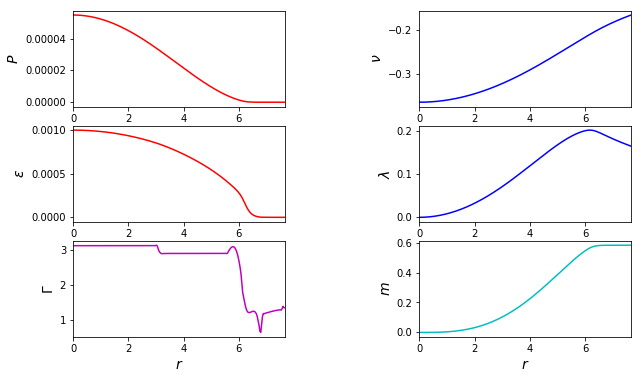

In [22]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 5), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 5), (2, 0), colspan=2)
ax4 = plt.subplot2grid((3, 5), (0, 3), colspan=2)
ax5 = plt.subplot2grid((3, 5), (1, 3), colspan=2)
ax6 = plt.subplot2grid((3, 5), (2, 3), colspan=2)

ax1.plot(values[:, 0], values[:, 3], 'r')
ax1.set_ylabel('$P$', fontsize=14)
ax1.set_xlim((0,R_last))

ax2.plot(values[:, 0], values[:, 2], 'r')
ax2.set_ylabel('$\epsilon$', fontsize=14)
ax2.set_xlim((0, R_last));

#ax3.plot(values[:, 0], values[:, 8], 'm')
#ax3.set_xlabel(r'$r$', fontsize=14)
#ax3.set_ylabel(r'$(\epsilon+P)^{-1}dP/dr$', fontsize=14)
#ax3.set_xlim((0, R_last));

ax3.plot(values[:, 0], values[:, 9], 'm')
ax3.set_xlabel(r'$r$', fontsize=14)
ax3.set_ylabel(r'$\Gamma$', fontsize=14)
ax3.set_xlim((0, R_last));

ax4.plot(values[:, 0], values[:, 5], 'b')
ax4.set_ylabel(r'$\nu$', fontsize=14)
ax4.set_xlim((0, R_last))

ax5.plot(values[:, 0], values[:, 6], 'b')
ax5.set_ylabel(r'$\lambda$', fontsize=14)
ax5.set_xlim((0, R_last));

ax6.plot(values[:, 0], values[:, 4], 'c')
ax6.set_ylabel(r'$m$', fontsize=14)
ax6.set_xlim((0, R_last));
ax6.set_xlabel(r'$r$', fontsize=14)

plt.show()

# Convert to CGS

In [23]:
c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Density = Msun/Length**3
dr_CGS = dr*Length
print('Number of grid points =', N_gridpoints)
print('rho_c =', rho_c*Density)
print('epsilon_c/c^2 =', eps_c*Density)
print('epsilon_c =', eps_c*Density*c**2)
print('P_c =', P_c*Density*c**2)
print('dr =', dr_CGS)
print('Radius of last grid point =', R_last*Length)
print('Extrapolated Radius at zero pressure =', Radius*Length)
print('Baryon Mass =', M0*Msun)
print('Gravitational Mass =', Mass*Msun)
print('Alternative Mass =', M_alt*Msun)
print('Rel. diff. in Mass =', M_reldiff)

Number of grid points = 248
rho_c = 590000000000000.0
epsilon_c/c^2 = 617794007964774.1
epsilon_c = 5.552364591654186e+35
P_c = 3.044940408469119e+34
dr = 4580.056459577529
Radius of last grid point = 1131273.9455156496
Extrapolated Radius at zero pressure = 1123933.2551541133
Baryon Mass = 1.2002836798994751e+33
Gravitational Mass = 1.1586191036363871e+33
Alternative Mass = 1.1579350242009023e+33
Rel. diff. in Mass = 0.0005904265114719438


In [24]:
values_CGS = np.zeros((idxlast+1, 10)) 

values_CGS[:, 0] = values[:, 0] * Length
values_CGS[:, 1] = values[:, 1] * Density  # rho
values_CGS[:, 2] = values[:, 2] * Density*c**2  # epsilon
values_CGS[:, 3] = values[:, 3] * Density*c**2  # P
values_CGS[:, 4] = values[:, 4] * Msun  # m
values_CGS[:, 5] = values[:, 5]         # nu
values_CGS[:, 6] = values[:, 6]         # lambda
values_CGS[:, 7] = values[:, 7] * c**2  # h
values_CGS[:, 8] = values[:, 8] / Length   # (epsilon+P)^{-1} dP/dr
values_CGS[:, 9] = values[:, 9]         # Gamma

# Write output files

In [25]:
np.savetxt('TOV_output.dat', values)
np.savetxt('TOV_output_CGS.dat', values_CGS)

# Convergence study

Using 11 different grid sizes (doubling the number of points each time), one can show a near 4th-order convergence of the code to machine accuracy. Notice that the order of covergence is basically set by the Taylor expansion at the center and by the accurate determination of the surface, since the Runge-Kutta integration between the center and the surface is a highly-accurate, adaptive step-size method. The mass contained between the last grid point with positive pressure and the true radius where the pressure vanishes is added by Simpson's rule, creating a midpoint by piecewise cubic Hermite interpolation of the last points inside the star. Furthermore, using the piecewise cubic Hermite interpolation to locate the true radius is critical for maintaining an overall near 4th order of convergence. 

In [26]:
display(Radius*Length/1e5, Mass)

11.239332551541132

0.5825133753827989

In [27]:
#different number of grid points used
Npoints = (51, 101, 201, 401, 801, 1601,  3201, 6401, 12801, 25601, 51201) 

#corresponding radii
Rpoints = (13.94172207620917, 13.941645678449056, 13.941655888703531, 
           13.941655855224191, 13.941655854982873, 13.941655855950778, 
           13.94165585620129, 13.941655856226983, 13.941655856226571, 
           13.94165585623217, 13.941655856231263)

#corresponding masses
Mpoints = (1.4146759258806558, 1.4145827900297967, 1.4145754433896565, 
           1.4145755137445708, 1.4145755180636626, 1.4145755182332922, 
           1.4145755175326402, 1.414575517523043, 1.414575517522602, 
           1.4145755175236454, 1.4145755175227888)


In [28]:
Nconv = 10
Ndiffpoints = np.zeros(Nconv)
Mdiffpoints = np.zeros(Nconv)
Rdiffpoints = np.zeros(Nconv)
Mdiffpoints_abs = np.zeros(Nconv)
Rdiffpoints_abs = np.zeros(Nconv)

for i in range(0,Nconv):
    Ndiffpoints[i] = Npoints[i]
    Mdiffpoints[i] = (Mpoints[Nconv]-Mpoints[i])/Mpoints[Nconv]
    Rdiffpoints[i] = (Rpoints[Nconv]-Rpoints[i])/Rpoints[Nconv]
    Mdiffpoints_abs[i] = np.abs(Mpoints[Nconv]-Mpoints[i])/Mpoints[Nconv]
    Rdiffpoints_abs[i] = np.abs(Rpoints[Nconv]-Rpoints[i])/Rpoints[Nconv]


In [29]:
display(Rdiffpoints)
display(Mdiffpoints)

array([-4.74979289e-06,  7.30026785e-07, -2.32915435e-09,  7.22347309e-11,
        8.95438712e-11,  2.01184832e-11,  2.14985001e-12,  3.06939410e-13,
        3.36499370e-13, -6.51083597e-14])

array([-7.09812637e-05, -5.14112320e-06,  5.24066276e-08,  2.67091994e-09,
       -3.82357664e-10, -5.02273244e-10, -6.96424678e-12, -1.79729586e-13,
        1.32010989e-13, -6.05586676e-13])

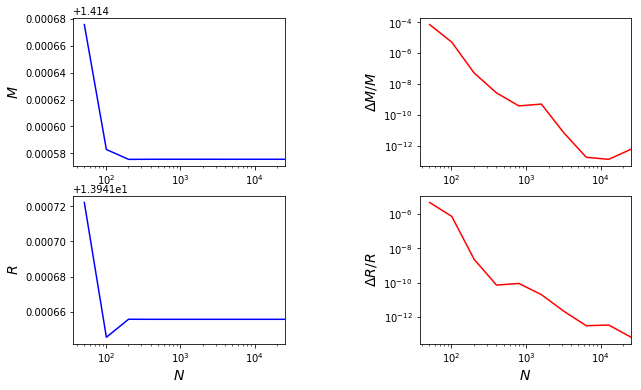

In [30]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=2)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2)
ax4 = plt.subplot2grid((2, 5), (1, 3), colspan=2)

ax1.plot(Npoints, Mpoints, 'b')
ax1.set_xscale("log")
ax1.set_ylabel('$M$', fontsize=14)
ax1.set_xlim((0,Npoints[Nconv-1]))

ax2.plot(Npoints, Rpoints, 'b')
ax2.set_xscale("log")
ax2.set_ylabel('$R$', fontsize=14)
ax2.set_xlim((0,Npoints[Nconv-1]))
ax2.set_xlabel('$N$', fontsize=14)

ax3.plot(Ndiffpoints, Mdiffpoints_abs, 'r')
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel('$\Delta M / M$', fontsize=14)
ax3.set_xlim((0,Npoints[Nconv-1]))

ax4.plot(Ndiffpoints, Rdiffpoints_abs, 'r')
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylabel('$\Delta R / R$', fontsize=14)
ax4.set_xlim((0,Npoints[Nconv-1]))
ax4.set_xlabel('$N$', fontsize=14)

plt.show()

Average convergence order:

In [31]:
( np.log10(Mdiffpoints_abs[5])-np.log10(Mdiffpoints_abs[0]))/( np.log10(Ndiffpoints[5])
                                                      - np.log10(Ndiffpoints[0]))

-3.440760883958844

In [32]:
( np.log10(Rdiffpoints_abs[5])-np.log10(Rdiffpoints_abs[0]))/( np.log10(Ndiffpoints[5])
                                                      - np.log10(Ndiffpoints[0]))

-3.589660273438458

In [33]:
np.log2( (Mpoints[1]- Mpoints[0] )/( Mpoints[2] - Mpoints[1]))

3.6641800984000725